## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

In [3]:
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/365
app_train['YEARS_BIRTH'].head()

0    25.920548
1    45.931507
2    52.180822
3    52.068493
4    54.608219
Name: YEARS_BIRTH, dtype: float64

In [4]:
# 等寬劃分
app_train['EQUAL_YEAR'] = pd.cut(app_train['YEARS_BIRTH'], 10)
app_train['EQUAL_YEAR'].value_counts()

(35.099, 39.959]    41758
(39.959, 44.819]    40350
(30.238, 35.099]    38430
(44.819, 49.679]    34311
(49.679, 54.54]     33544
(25.378, 30.238]    33127
(54.54, 59.4]       32650
(59.4, 64.26]       27685
(20.469, 25.378]    13679
(64.26, 69.121]     11977
Name: EQUAL_YEAR, dtype: int64

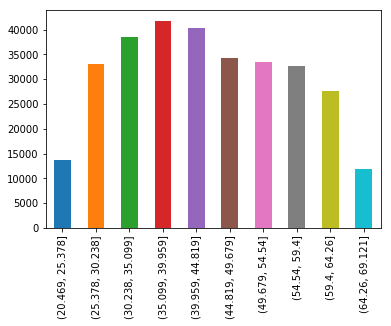

In [5]:
app_train['EQUAL_YEAR'].value_counts().sort_index().plot(kind='bar');

In [6]:
# 等頻劃分
# pandas.qcut() 是依照分位數來決定分割區間後，所以有可能各組數據量會有不同
app_train['EQUAL_FREQ_YEAR'] = pd.qcut(app_train['YEARS_BIRTH'], 10)
app_train['EQUAL_FREQ_YEAR'].value_counts()

(43.151, 47.178]    30764
(28.175, 32.038]    30760
(36.0, 39.496]      30759
(51.74, 56.093]     30758
(56.093, 60.77]     30757
(20.517, 28.175]    30752
(39.496, 43.151]    30745
(32.038, 36.0]      30745
(60.77, 69.121]     30738
(47.178, 51.74]     30733
Name: EQUAL_FREQ_YEAR, dtype: int64

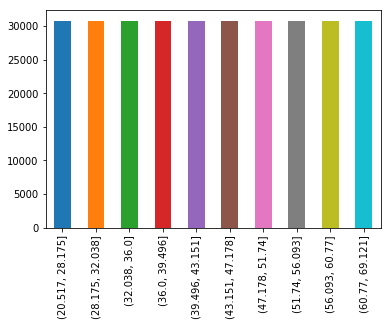

In [7]:
app_train['EQUAL_FREQ_YEAR'].value_counts().sort_index().plot(kind='bar');

In [8]:
# 自定義的 bin
print(app_train['YEARS_BIRTH'].describe())
cut_rule = [20, 30, 40, 50, 60, 70]
app_train['CUST_YEARS_BIRTH'] = pd.cut(app_train['YEARS_BIRTH'], cut_rule)
app_train['CUST_YEARS_BIRTH'].value_counts()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: YEARS_BIRTH, dtype: float64


(30, 40]    82308
(40, 50]    76541
(50, 60]    68062
(20, 30]    45021
(60, 70]    35579
Name: CUST_YEARS_BIRTH, dtype: int64

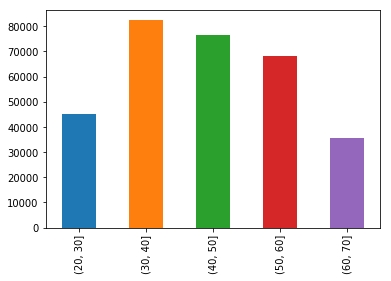

In [9]:
app_train['CUST_YEARS_BIRTH'].value_counts().sort_index().plot(kind='bar');

## 連續型特徵離散化
雖然由之前的分析發現 DAYS_BIRTH 與 TARGET 的相關係數只有 -0.07，但直覺上這個變數應該會提供模型不少訊息

In [12]:
print("Correlation between TARGET and DAYS_BIRTH", app_train['DAYS_BIRTH'].corr(app_train['TARGET']))
app_train['YEARS_BIRTH'].describe()

Correlation between TARGET and DAYS_BIRTH -0.07823930830982712


count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: YEARS_BIRTH, dtype: float64

年齡最小是 20，最大是 69，那我們可以把年齡每 5 歲為一組後再來觀察其與預測目標的關係

In [13]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'YEARS_BIRTH']]

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/home/ryanyao/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,TARGET,YEARS_BIRTH,YEARS_BINNED
0,1,25.920548,"(25.0, 30.0]"
1,0,45.931507,"(45.0, 50.0]"
2,0,52.180822,"(50.0, 55.0]"
3,0,52.068493,"(50.0, 55.0]"
4,0,54.608219,"(50.0, 55.0]"
5,0,46.413699,"(45.0, 50.0]"
6,0,37.747945,"(35.0, 40.0]"
7,0,51.643836,"(50.0, 55.0]"
8,0,55.065753,"(55.0, 60.0]"
9,0,39.641096,"(35.0, 40.0]"


In [14]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,YEARS_BIRTH
YEARS_BINNED,,
"(20.0, 25.0]",0.123036,23.377522
"(25.0, 30.0]",0.111436,27.822518
"(30.0, 35.0]",0.102814,32.479037
"(35.0, 40.0]",0.089414,37.555913
"(40.0, 45.0]",0.078491,42.459346
"(45.0, 50.0]",0.074171,47.462741
"(50.0, 55.0]",0.066968,52.593136
"(55.0, 60.0]",0.055314,57.491131
"(60.0, 65.0]",0.052737,62.412459


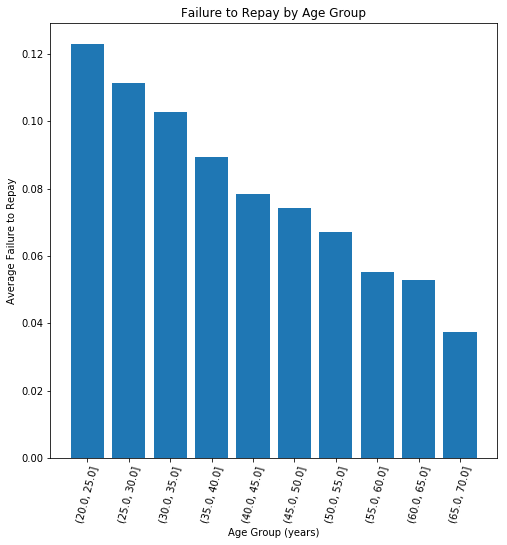

In [15]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(range(len(age_groups.index)), age_groups['TARGET'])
# Plot labeling
plt.xticks(range(len(age_groups.index)), age_groups.index, rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Age Group');

可以非常明顯地看出趨勢，越年輕的客戶族群的違約遲繳的可能越大！
